В домашнем задании нужно решить задачу классификации типа стекол. Целевая переменная – тип стекла «Type». Остальные признаки описывают химические элементы в составе материала. Датасет нужно исследовать на наличие выбросов, провести EDA.

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN

1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).

Type of glass: (class attribute)
* building_windows_float_processed
* building_windows_non_float_processed
* vehicle_windows_float_processed
* vehicle_windows_non_float_processed (none in this database)
* containers
* tableware
* headlamps

In [159]:
data = pd.read_csv('glass.csv')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


2. Проведите первичный анализ.
* Проверьте количество записей для каждого класса. Сделайте вывод.

In [160]:
data['Fe'].unique()

array([0.  , 0.26, 0.11, 0.24, 0.17, 0.07, 0.19, 0.14, 0.22, 0.06, 0.3 ,
       0.16, 0.1 , 0.09, 0.31, 0.03, 0.12, 0.32, 0.15, 0.2 , 0.34, 0.28,
       0.08, 0.29, 0.21, 0.18, 0.25, 0.35, 0.37, 0.51, 0.05, 0.01])

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [162]:
data.columns

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], dtype='object')

In [163]:
X = data[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]
y = data['Type']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Обучите модель дерева решений RandomForestClassifier на обучающем множестве.

In [165]:
tree = RandomForestClassifier(random_state=42)
tree.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (accuracy).

In [166]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [167]:
# Переобучение

accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy train: {accuracy:.4f}')
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy test: {accuracy:.4f}')

Accuracy train: 1.0000
Accuracy test: 0.8372


In [168]:
# Подберем параметры с помощью GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Accuracy: {grid_search.best_score_:.2f}')

best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Лучшие параметры: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.77


In [169]:
accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy train: {accuracy:.4f}')
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy test: {accuracy:.4f}')

Accuracy train: 0.9474
Accuracy test: 0.7907


6. Обработайте выбросы в данных.
* Визуализируйте распределение значений для каждой переменной. Можно использовать функции sns.boxplot, sns.distplot. Есть ли признаки с нормальным распределением?
* Исследуйте признаки на выбросы несколькими способами.
* Удалите выбросы. *Посчитайте процент удаленных записей от общего числа записей для каждого класса.

In [170]:
data.head(2)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1


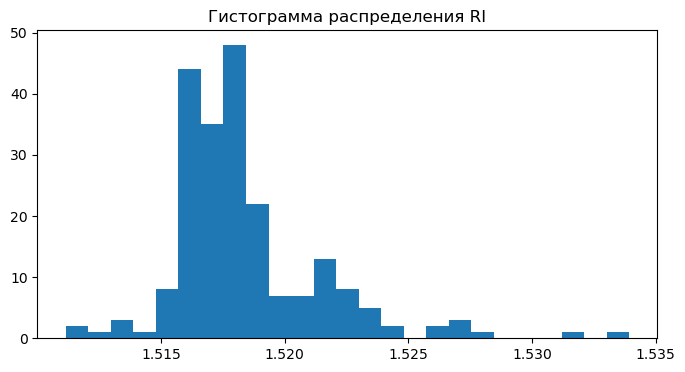

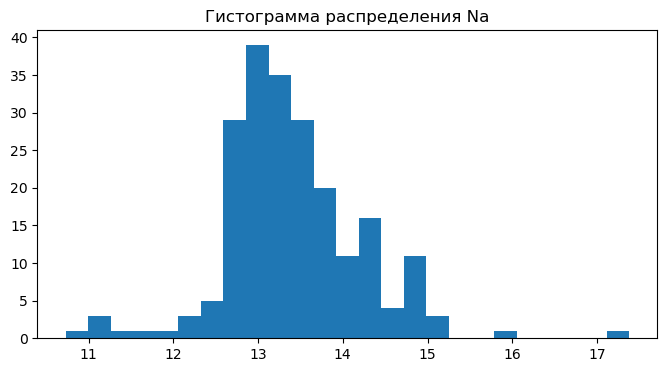

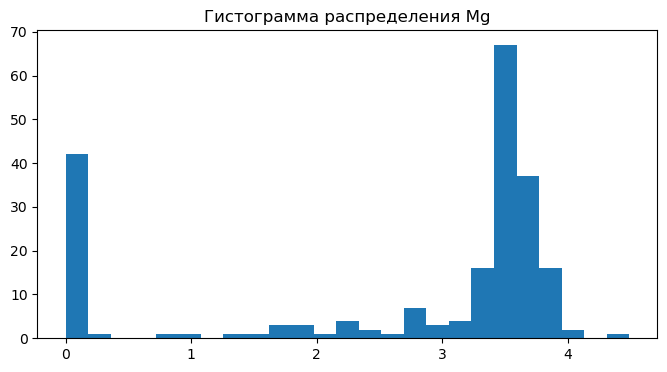

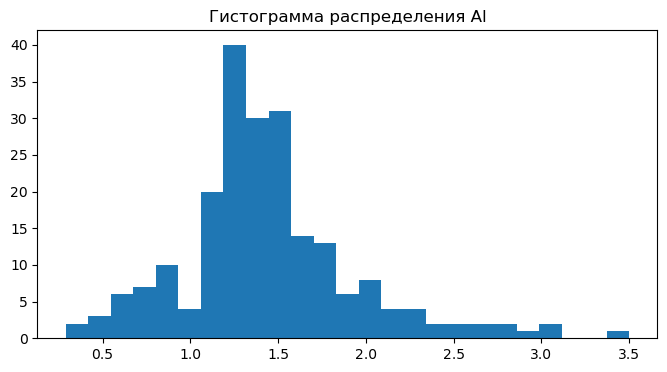

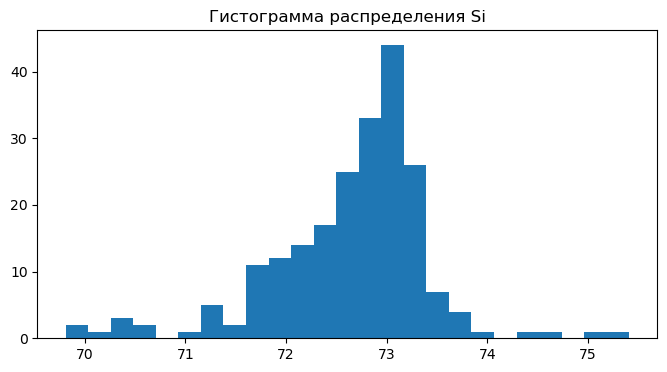

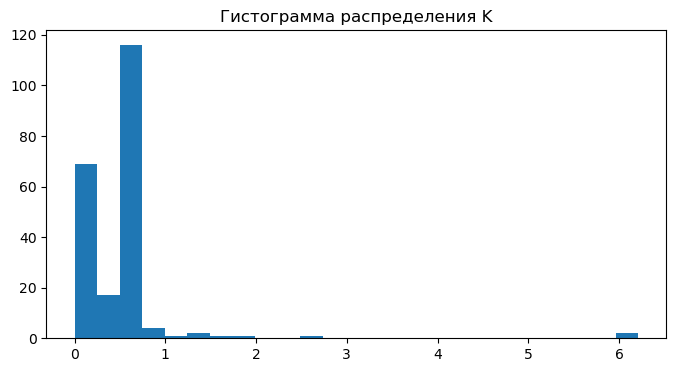

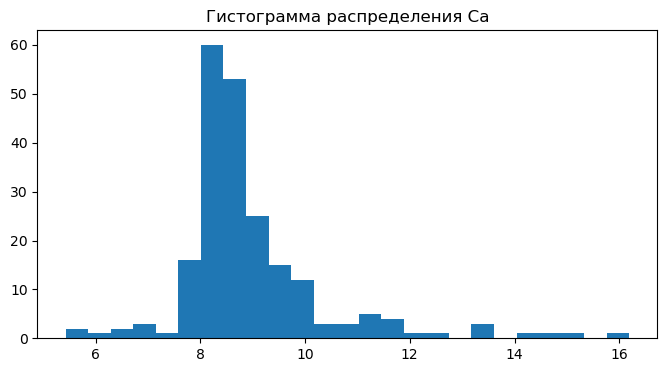

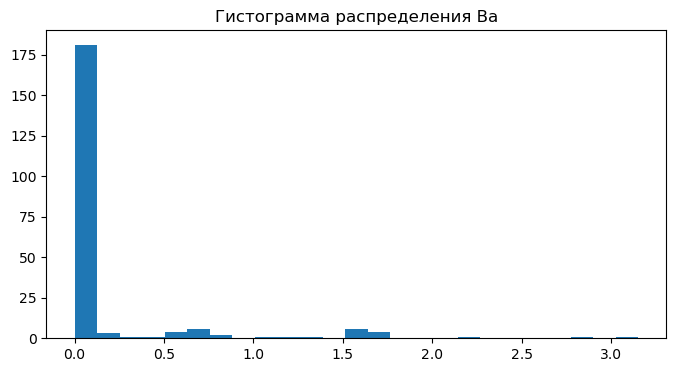

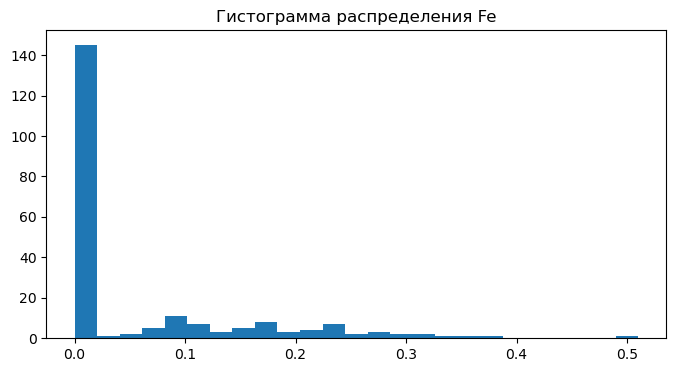

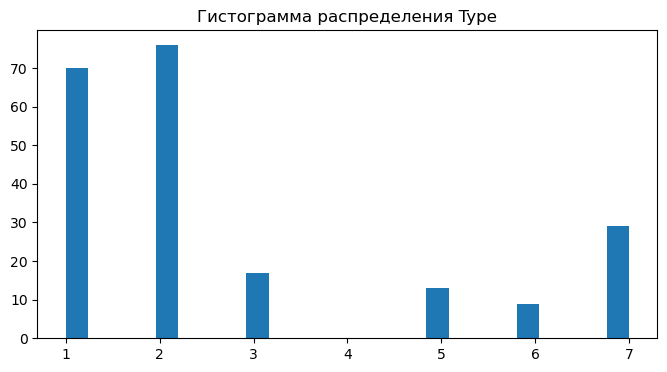

In [171]:
# Согласно графику ни один из признаков не распределен нормально
                               
for feature in list(data.columns):
    plt.figure(figsize=(8,4))
    plt.hist(data[feature], bins=25)
    plt.title(f'Гистограмма распределения {feature}')
    plt.show()

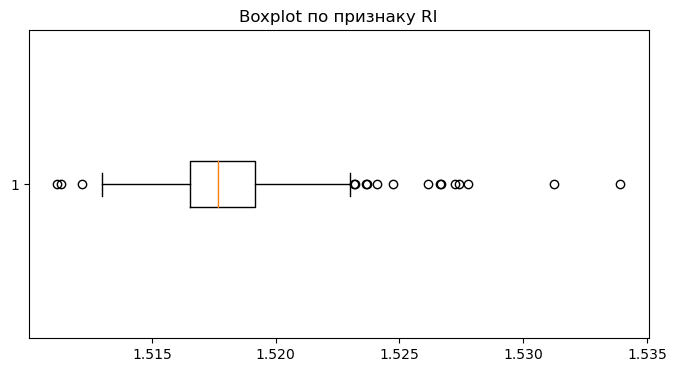

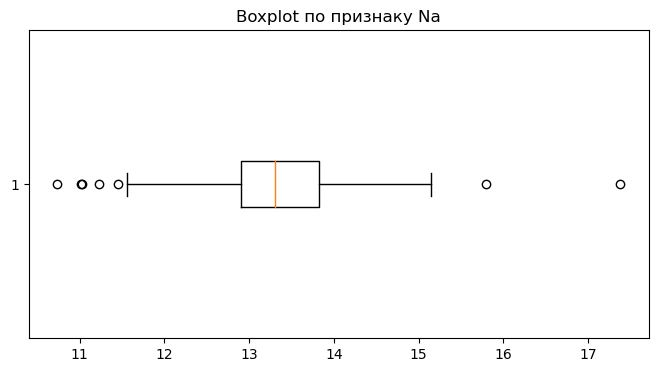

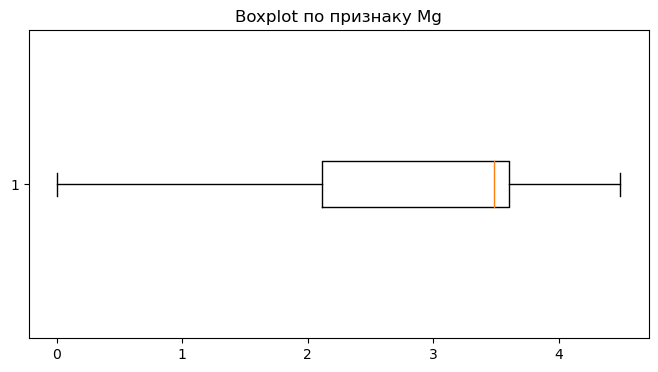

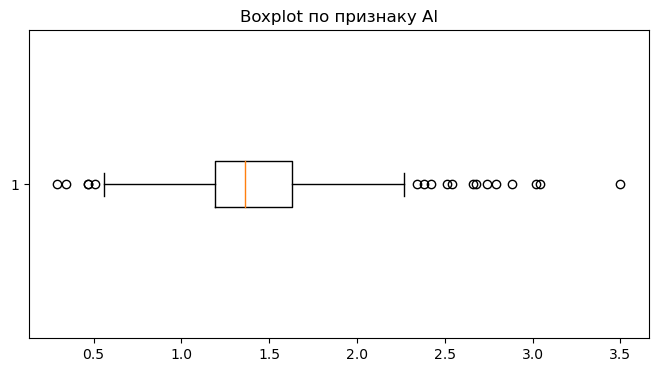

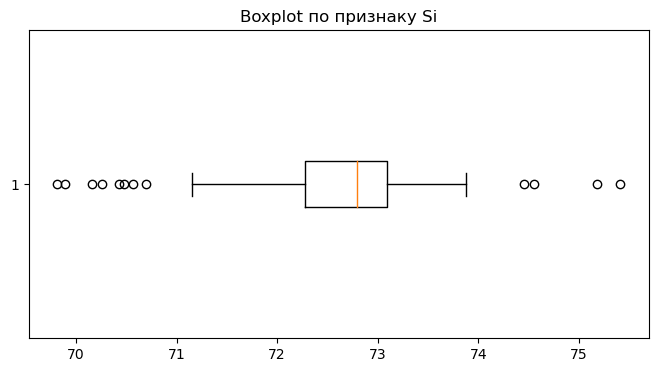

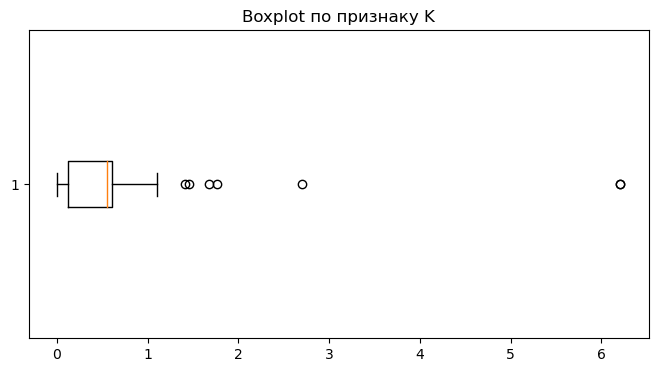

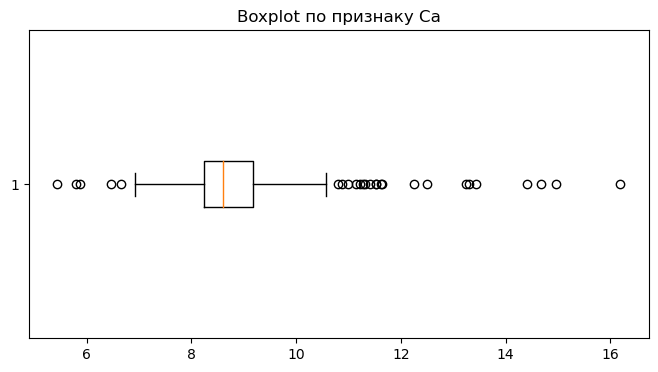

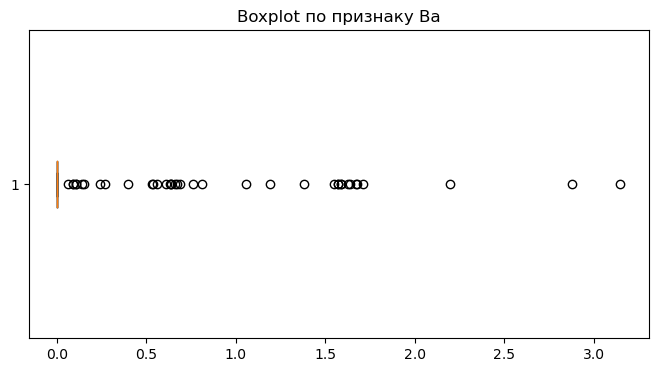

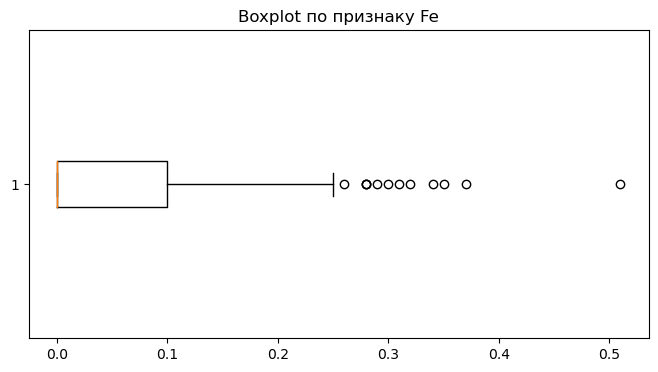

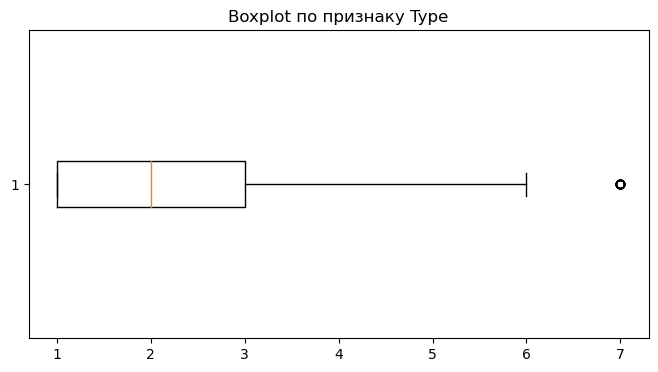

In [172]:
# Визуализируем boxplot для всех признаков 

for feature in list(data.columns):
    plt.figure(figsize=(8,4))
    plt.boxplot(data[feature], vert=False)
    plt.title(f'Boxplot по признаку {feature}')
    plt.show()

In [173]:
# Удалим выбросы
all_outliers = []

for feature in list(data.drop('Type',axis=1).columns):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    all_outliers.extend(outliers.index)

    print(f'Признак: {feature}')
    print(f'Выбросы: {len(outliers)}')
    print(f'Границы: {lower_bound:.3f}, {upper_bound:.3f}')

Признак: RI
Выбросы: 17
Границы: 1.513, 1.523
Признак: Na
Выбросы: 7
Границы: 11.531, 15.201
Признак: Mg
Выбросы: 0
Границы: -0.113, 5.828
Признак: Al
Выбросы: 18
Границы: 0.530, 2.290
Признак: Si
Выбросы: 12
Границы: 71.069, 74.299
Признак: K
Выбросы: 7
Границы: -0.609, 1.341
Признак: Ca
Выбросы: 26
Границы: 6.841, 10.571
Признак: Ba
Выбросы: 38
Границы: 0.000, 0.000
Признак: Fe
Выбросы: 12
Границы: -0.150, 0.250


In [174]:
outliers_data = data.loc[all_outliers]
outliers_data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
47,1.52667,13.99,3.70,0.71,71.57,0.02,9.82,0.0,0.10,1
50,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1
56,1.51215,12.99,3.47,1.12,72.98,0.62,8.35,0.0,0.31,1
103,1.52725,13.80,3.15,0.66,70.57,0.08,11.64,0.0,0.00,2
104,1.52410,13.83,2.90,1.17,71.15,0.08,10.79,0.0,0.00,2


In [175]:
outliers_data['RI'].sort_values().unique()

array([1.51115, 1.51131, 1.51215, 1.51299, 1.51316, 1.51321, 1.51508,
       1.51514, 1.51531, 1.51545, 1.51556, 1.51596, 1.51602, 1.51609,
       1.51613, 1.51617, 1.51623, 1.5164 , 1.51645, 1.51651, 1.51653,
       1.51655, 1.51658, 1.51662, 1.51673, 1.51683, 1.51685, 1.51711,
       1.51719, 1.51727, 1.51732, 1.51775, 1.51786, 1.51789, 1.51811,
       1.51818, 1.51831, 1.51838, 1.51839, 1.51848, 1.51851, 1.51909,
       1.51916, 1.51934, 1.51966, 1.51969, 1.51977, 1.51994, 1.52043,
       1.52058, 1.52065, 1.52068, 1.52119, 1.52151, 1.52171, 1.52177,
       1.52211, 1.52213, 1.52222, 1.52247, 1.52315, 1.5232 , 1.52365,
       1.52369, 1.5241 , 1.52475, 1.52614, 1.52664, 1.52667, 1.52725,
       1.52739, 1.52777, 1.53125, 1.53393])

In [176]:
set_outliers = set(all_outliers)
print(f'Количество выбросов: {len(set_outliers)}')
print(f'Процент выбросов: {len(set_outliers) / len(data) * 100:.2f}%')

Количество выбросов: 78
Процент выбросов: 36.45%


In [177]:
# Количество выбросов довольно большое

data_cleaned = data.drop(set_outliers)
print(f'Строк после удаления: {len(data_cleaned)} строк')

Строк после удаления: 136 строк


In [178]:
data_cleaned['RI'].sort_values().unique()

array([1.51409, 1.51567, 1.51569, 1.51571, 1.51574, 1.51588, 1.51589,
       1.5159 , 1.51592, 1.51593, 1.51594, 1.51596, 1.51605, 1.5161 ,
       1.51613, 1.51618, 1.51625, 1.51627, 1.51629, 1.51631, 1.5164 ,
       1.51643, 1.51645, 1.51646, 1.51652, 1.51655, 1.5166 , 1.51663,
       1.51665, 1.51666, 1.51667, 1.5167 , 1.51674, 1.51687, 1.51689,
       1.5169 , 1.51694, 1.51707, 1.51708, 1.51709, 1.51711, 1.5172 ,
       1.51721, 1.5173 , 1.51735, 1.51736, 1.51742, 1.51743, 1.51747,
       1.51748, 1.5175 , 1.51751, 1.51753, 1.51754, 1.51755, 1.51756,
       1.51761, 1.51763, 1.51764, 1.51766, 1.51768, 1.51769, 1.51776,
       1.51778, 1.51779, 1.51783, 1.51784, 1.51793, 1.51796, 1.51797,
       1.518  , 1.51806, 1.51808, 1.51811, 1.51813, 1.5182 , 1.51824,
       1.51829, 1.51832, 1.51837, 1.51841, 1.51844, 1.51846, 1.51847,
       1.51852, 1.5186 , 1.51869, 1.51872, 1.51888, 1.51892, 1.51898,
       1.519  , 1.51905, 1.51911, 1.51915, 1.51918, 1.51926, 1.51937,
       1.5202 , 1.52

7. Повторите п. 4, п. 5.

In [179]:
X = data_cleaned[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]
y = data_cleaned['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [181]:
accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy train: {accuracy:.4f}')
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy test: {accuracy:.4f}')

Accuracy train: 0.9167
Accuracy test: 0.9286


In [182]:
# Определим выбросы с помощью DBSCAN

X = data[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=2, min_samples=10)  
clusters = dbscan.fit_predict(X_scaled)

data['is_outlier'] = (clusters == -1).astype(int)

# Количество выбросов
outliers = data[data['is_outlier'] == 1]

print(f'Количество выбросов: {len(outliers)}')
print(f'Процент выбросов: {len(outliers) / len(data) * 100:.2f}%')

Количество выбросов: 30
Процент выбросов: 14.02%


In [183]:
# Удалим выбросы

data_dbscan = data[data['is_outlier'] == 0]
print(f'Строк после удаления: {len(data_dbscan)} строк')

Строк после удаления: 184 строк


In [184]:
X = data_dbscan[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]
y = data_dbscan['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [186]:
accuracy = accuracy_score(y_train, y_train_pred)
print(f'Accuracy train: {accuracy:.4f}')
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy test: {accuracy:.4f}')

Accuracy train: 0.9184
Accuracy test: 0.8919


8. Сформулируйте выводы по проделанной работе.
* Кратко опишите, какие преобразования были сделаны с данными.
* Сравните точность двух моделей.
* Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.

### Обучили модель дерева решений на исходном датасете, получили accuracy - 79%. Далее обучили модель без учета выбросов, повысили показатель метрики до 93%, но выбросами убрали 36% данных. С помощью DBSCAN убрали 14% выбросных данных, метрика 89%.